In [2]:
import numpy as np
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler import generate_preset_pass_manager
import qiskit_ibm_runtime.fake_provider as fk  
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler import Layout, CouplingMap
import matplotlib.pyplot as plt
import warnings
#supress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Benchmarking Notebook

- This notebook is designed to benchmark the performance of the Adaptive Cyclic Layout Map algorithm, i.e ACLM.
- The ACLM optimizes the layout transpiler pass (hardware aware mapping of logical qubits to physical qubits)
- See the jupyter notebook: `adaptive cyclic layout map.ipynb` for an introduction to the algorithm, as well as relevant use cases.

## Objectives

- We compare the ACLM pass (and approx ACLM pass) to the native qiskit passes: 'sabre', 'trivial', and 'dense' 
- We focus on measuring **circuit depth**, and **CNOT gates** (native entangling gates) for different implementations of the layout transpiler passes
- The comparison is performed with respect to **different circuit sizes (# of qubits)** as well as **different harware backends**
- We show that the ACLM (and approx ACLM) passes outperform the given native passes by reducing the circuit depth and CNOT 

----

The notebook is organized as follows:

- [Initialize ACLM functions](#initialize-aclm-functions)
- [Benchmarking: number of qubits](#benchmarking-with-respect-to-number-of-qubits)
- [Benchmarking: hardware backends](#benchmarking-with-respect-to-different-hardware-backends)

---

### Initialize ACLM functions ###

The functions defined below find the best simple cycle for  a given circuit.
See the jupyter notebook: `adaptive cyclic layout map.ipynb`  for an introduction to the algorithm, as well as relevant use cases.

For a given hardware, Logical qubits are mapped to physical qubits in a cyclic order.
- Uses the Networkx python package to represent the coupling map (for a given backend hardware) as a graph, and then finds the set of simple cycles in the graph
- For a given circuit with n-qubits, we try to obtain a cycle with length n

In [10]:

def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Finds an exact cycle of length n, else return the nearest larger cycle.
    Inputs:
        coupling_map: CouplingMap object representing the hardware connectivity
        n: Desired cycle length
    Returns:
        A cycle of length n if found, otherwise the smallest larger cycle, or None if no cycles exist.
    """
    #Convert CouplingMap to NetworkX graph
    G = nx.Graph()

    #Add edges from the coupling map to the NetwrkX graph object
    G.add_edges_from(coupling_map.get_edges())

    #Find all simple cycles in the graph
    cycles = list(nx.simple_cycles(G))

    #cycles with desired length n
    exact = [c for c in cycles if len(c) == n]
    #cycles with length larger than n
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):

    """
    Adaptive layout for ring circuits: suggests ancilla qubits if needed
    Inputs: 
        logical_qubits: Number of logical qubits in the circuit
        coupling_map: CouplingMap object representing the hardware connectivity

    Returns:
        required_qubits: Total number of qubits needed (logical + ancilla)
        ancilla: Number of ancilla qubits required (if any)

    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits


    return required_qubits, ancilla


___
### Benchmarking with respect to number of qubits ###

- The cell below transpiles 2-Local real amplitude circuits of *different sizes*, and compares the physical resources necessary to execute the circuit.
- The n-dependent results are compared across different transpiler passes
- The SEED, optimization-level, and backend are kept constant for consistency.

In [28]:
#Fix the random seed for reproducibility and consistency
SEED = 42

#Different numbers of qubits to benchmark
n_s = [6, 9, 12, 15, 18, 20, 25, 30, 50, 65]

#Initialize dictionaries to store results (depth and CNOT counts) for each layout method
depth_count = {"sabre": [], "trivial": [], "dense": [], "ACLM": [], "approx ACLM": []}
cnot_count = {"sabre": [], "trivial": [], "dense": [], "ACLM": [], "approx ACLM": []}

# Use the Washington backend as an example
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

#Helper function to create a transpiler pass manager
#Optimization level is set to 2
def create_pass_manager(layout_method=None, initial_layout=None):
    return generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method=layout_method,
        initial_layout=initial_layout,
        seed_transpiler=SEED
    )

#Helper function to transpile and record results (depth and CNOT counts) for each layout method
def transpile_and_record(qc, pass_manager, method_name):
    transpiled = pass_manager.run(qc)
    depth_count[method_name].append(transpiled.depth())
    cnot_count[method_name].append(transpiled.count_ops().get("cx", 0))

#Main benchmarking loop scaling over different numbers of qubits
for n in n_s:
    # Calculate the condition for an n-qubit simple cycle graph
    required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

    #Circuit with n-qubits (may or may not equal to required_qubits,
    #i.e. may require ancilla qubits to form a simple cycle)
    qc = RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)

    #Circuit with required_qubits (definitely forms a simple cycle)
    qc_cyclic = RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

    #Transpile using Qiskit native layout methods
    for method in ["sabre", "trivial", "dense"]:
        pass_manager = create_pass_manager(layout_method=method)
        transpile_and_record(qc, pass_manager, method)

    #Find the best cycle for custom layouts
    cycle = find_best_cycle(cm, required_qubits)

    #Transpile using ACLM (full cycle)
    layout_cyclic = Layout({qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)})
    pass_manager_cycle = create_pass_manager(initial_layout=layout_cyclic)
    transpile_and_record(qc_cyclic, pass_manager_cycle, "ACLM")

    #Transpile using approximate ACLM
    layout_approx = Layout({qc.qubits[i]: cycle[i] for i in range(n)})
    pass_manager_approx = create_pass_manager(initial_layout=layout_approx)
    transpile_and_record(qc, pass_manager_approx, "approx ACLM")

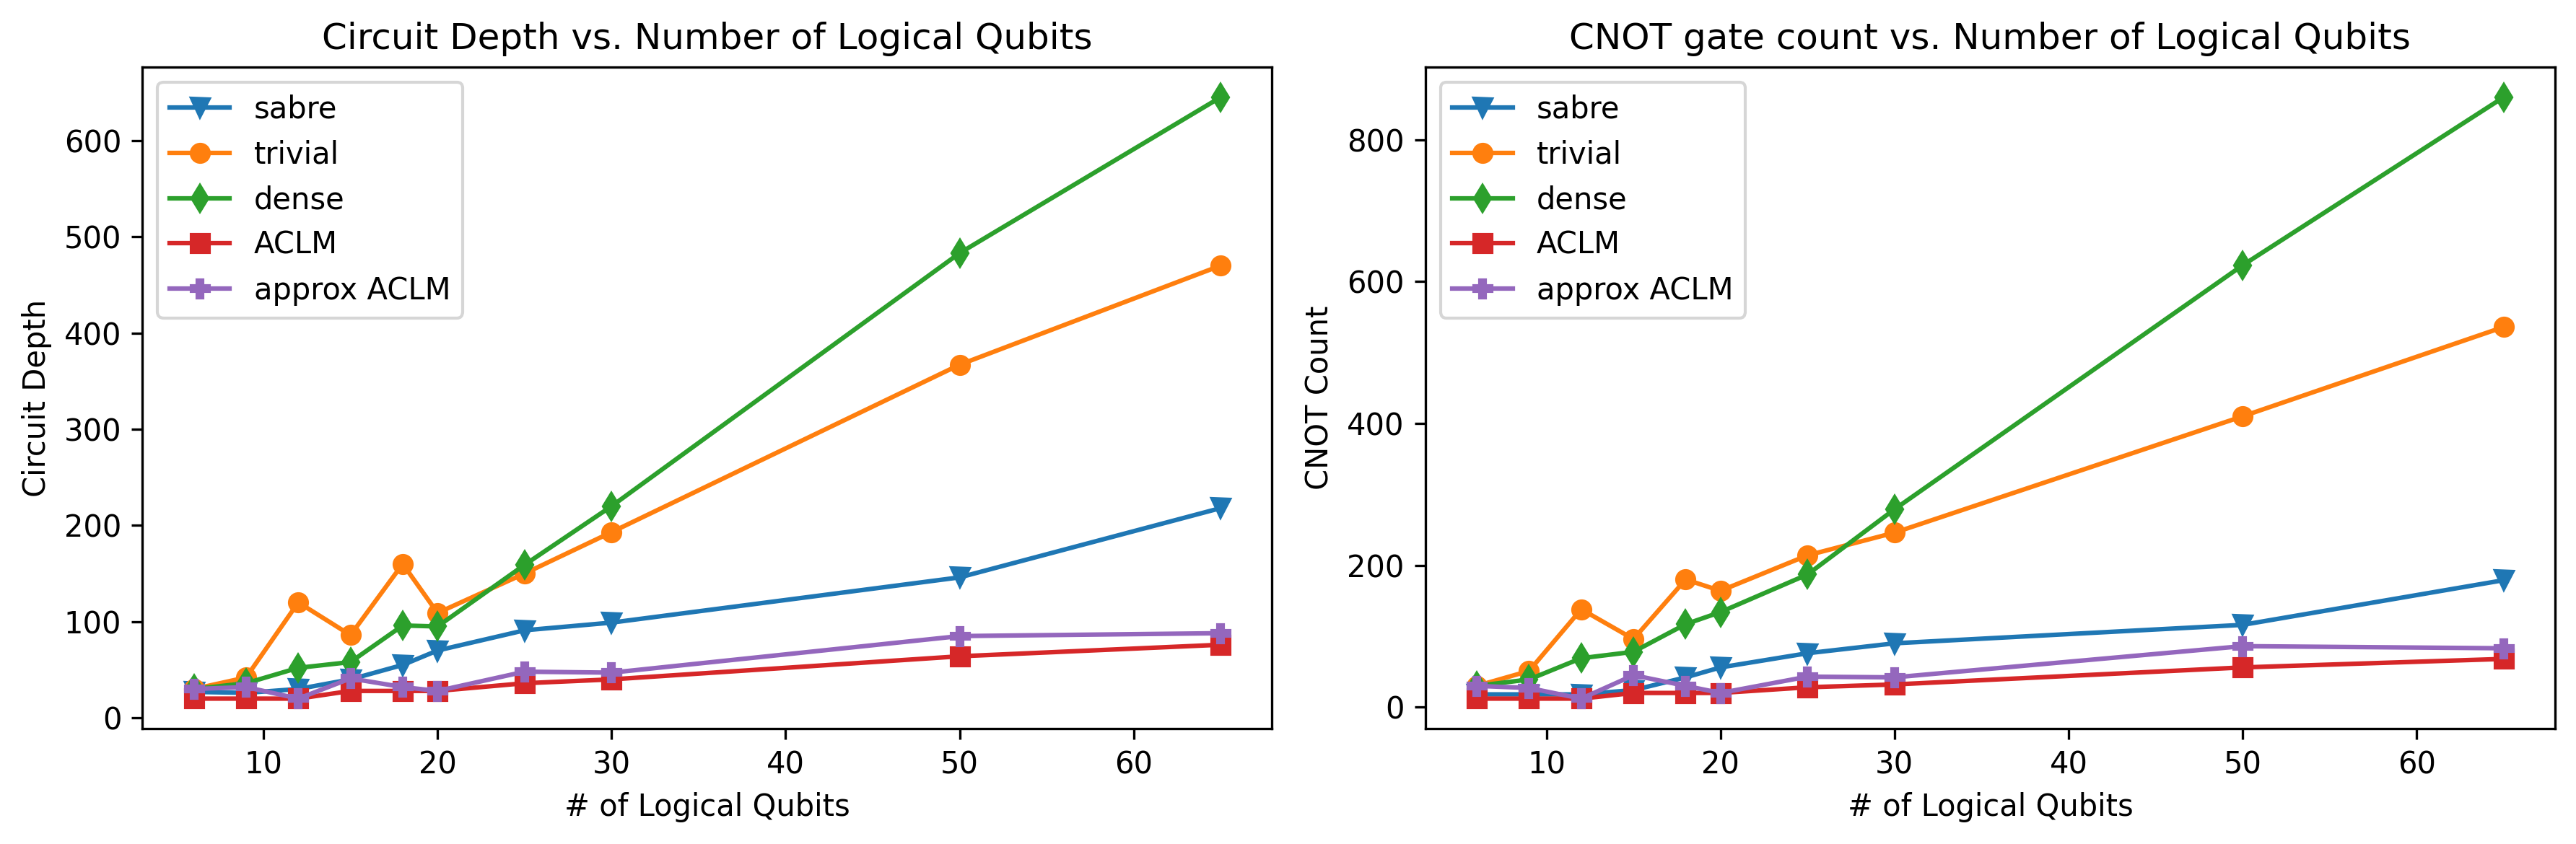

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=300)
#Plot markers for different layout methods
marker_style= {"sabre": "v-", "trivial": "o-", "dense": "d-", "ACLM": "s-", "approx ACLM": "P-"}
ax = axs[0]

for method, marker in marker_style.items():
    ax.plot(n_s, depth_count[method], marker, label=method)

ax.set_xlabel('# of Logical Qubits')
ax.set_ylabel('Circuit Depth')
ax.set_title('Circuit Depth vs. Number of Logical Qubits')
ax.legend()

ax = axs[1]
for method, marker in marker_style.items():
    ax.plot(n_s, cnot_count[method], marker, label=method)

ax.set_xlabel('# of Logical Qubits')
ax.set_title('CNOT gate count vs. Number of Logical Qubits')
ax.set_ylabel('CNOT Count')
ax.legend()

plt.tight_layout()

As predicted, we see that for high-n the ACLM and the approximate ACLM **increasingly outperforms the given native passes** (not vf2++)
by simultaneously reducing the circuit depth and number of entangling CNOT gates required to execute the physical circuit
___

### Benchmarking with respect to different hardware backends ###

- The cell below transpiles the same 2-Local real amplitude circuits, and compares the physical resources necessary to execute the circuit in *different backends*.
- The backend-dependent results are compared across different transpiler passes
- The SEED, optimization-level, and number-of-qubits are kept constant for consistency.

In [30]:
#Fix the random seed for reproducibility and consistency
SEED = 42

#Fix the number of qubits for benchmarking with respect to backends
n=35

#List of backends to benchmark
backend_list = [fk.FakeWashingtonV2(), fk.FakeOsaka(), fk.FakeSherbrooke(),fk.FakeBrooklynV2()]

#Initialize dictionaries to store results (depth and CNOT counts) for each layout method
depth_count = {"sabre": [], "trivial": [], "dense": [], "ACLM": [], "approx ACLM": []}
cnot_count = {"sabre": [], "trivial": [], "dense": [], "ACLM": [], "approx ACLM": []}
transpiled_circ = {"sabre": [], "trivial": [], "dense": [], "ACLM": [], "approx ACLM": []}


#Helper function to create a transpiler pass manager
#Optimization level is set to 2
def create_pass_manager(backend, layout_method=None, initial_layout=None):
    return generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method=layout_method,
        initial_layout=initial_layout,
        seed_transpiler=SEED
    )

#Helper function to transpile and record results (depth and CNOT (or corresponding 2-qubit gate) counts) for each layout method
def transpile_and_record(qc, pass_manager, method_name):
    transpiled = pass_manager.run(qc)
    depth_count[method_name].append(transpiled.depth())
    cnot_count[method_name].append(transpiled.count_ops().get("cx", 0) + transpiled.count_ops().get("ecr", 0))
    transpiled_circ[method_name].append(transpiled)

#Main benchmarking loop scaling over different backends
for backend in backend_list:
    #Use the backend's coupling map
    cm = CouplingMap(backend.configuration().coupling_map)

    print(f"{n} qubit circuit transpiled with backend: {backend.name}")
    # Calculate the condition for an n-qubit simple cycle graph
    required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

    #Circuit with n-qubits (may or may not equal to required_qubits,
    #i.e. may require ancilla qubits to form a simple cycle)
    qc = RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)

    #Circuit with required_qubits (definitely forms a simple cycle)
    qc_cyclic = RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

    #Transpile using Qiskit native layout methods
    for method in ["sabre", "trivial", "dense"]:
        pass_manager = create_pass_manager(backend,layout_method=method)
        transpile_and_record(qc, pass_manager, method)

    #Find the best cycle for custom layouts
    cycle = find_best_cycle(cm, required_qubits)

    #Transpile using ACLM (full cycle)
    layout_cyclic = Layout({qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)})
    pass_manager_cycle = create_pass_manager(backend, initial_layout=layout_cyclic)
    transpile_and_record(qc_cyclic, pass_manager_cycle, "ACLM")

    #Transpile using approximate ACLM
    layout_approx = Layout({qc.qubits[i]: cycle[i] for i in range(n)})
    pass_manager_approx = create_pass_manager(backend, initial_layout=layout_approx)
    transpile_and_record(qc, pass_manager_approx, "approx ACLM")

35 qubit circuit transpiled with backend: fake_washington
35 qubit circuit transpiled with backend: fake_osaka
35 qubit circuit transpiled with backend: fake_sherbrooke
35 qubit circuit transpiled with backend: fake_brooklyn


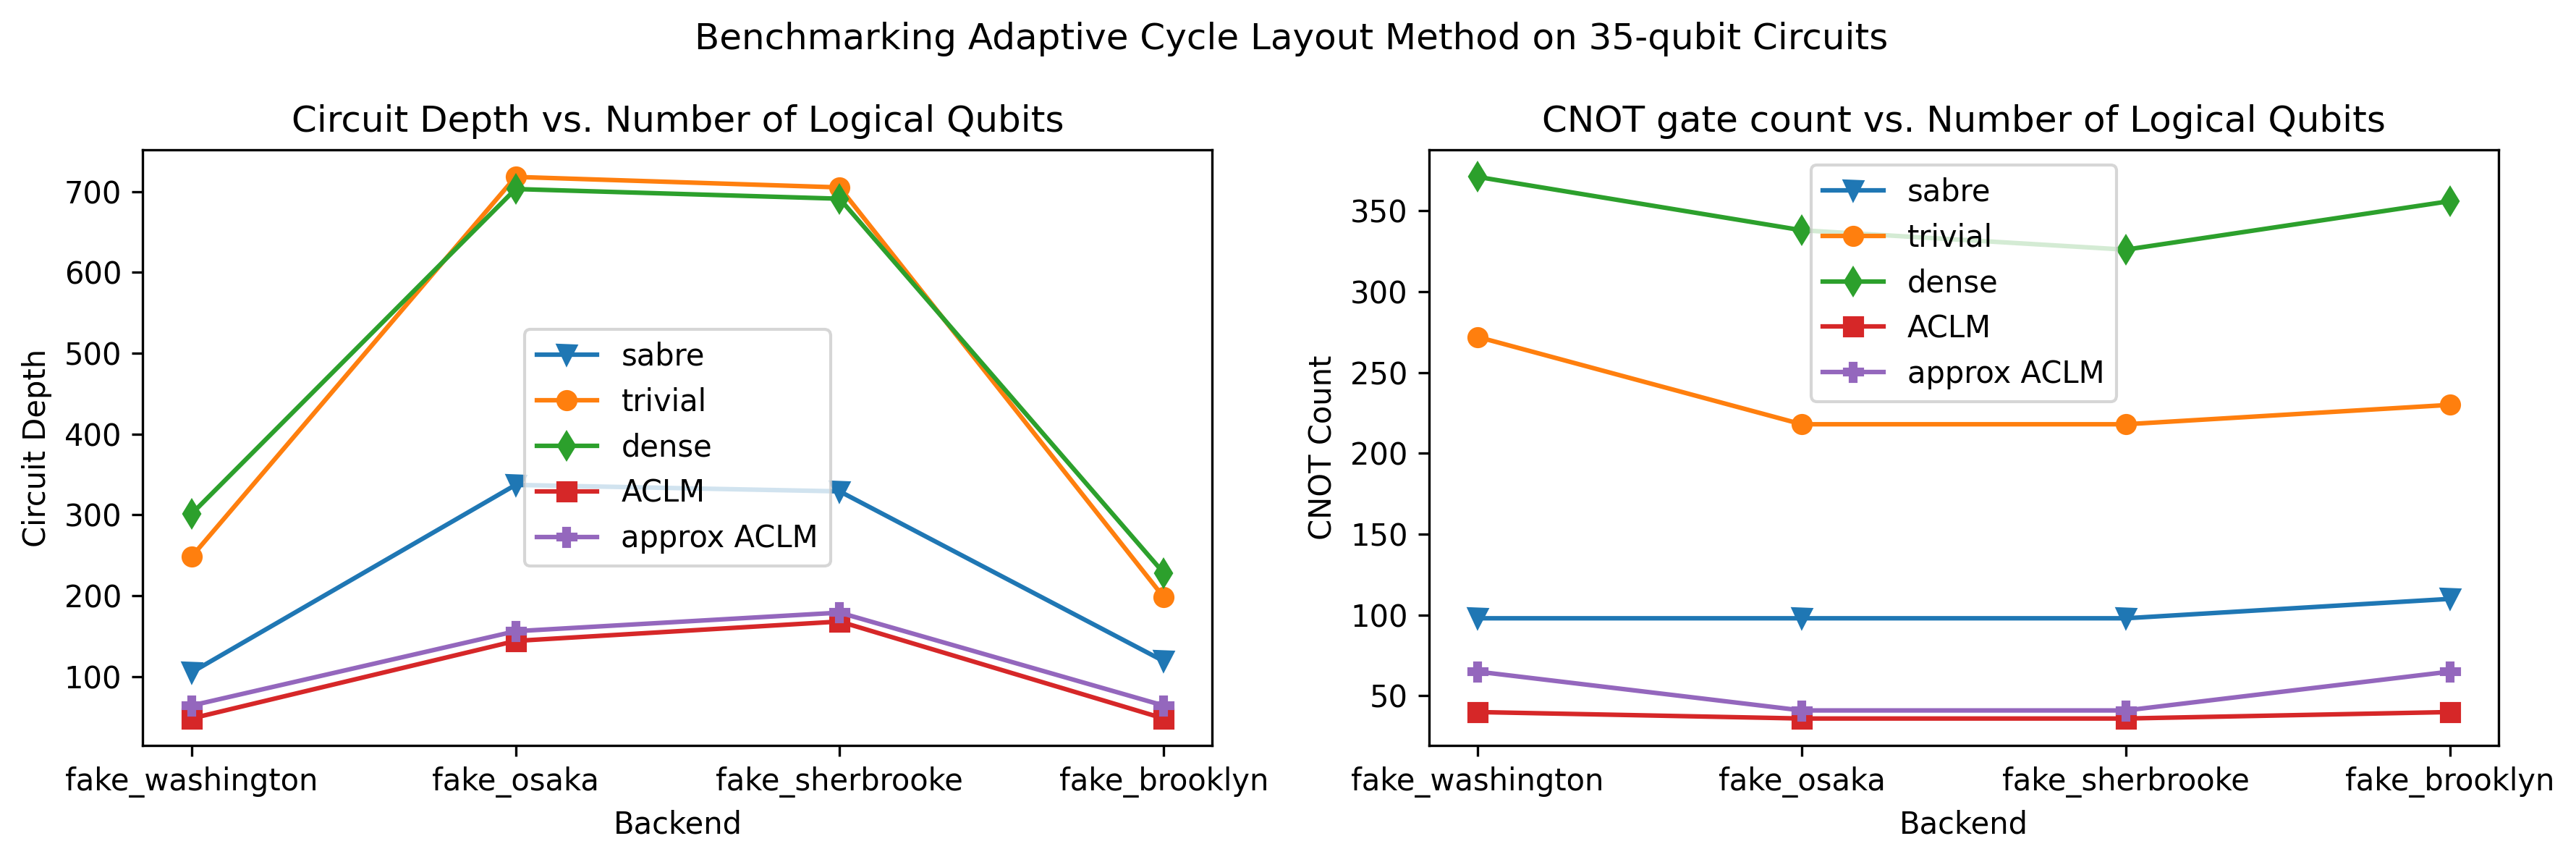

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=300)
backend_names = [backend.name for backend in backend_list]
#Plot markers for different layout methods
marker_style= {"sabre": "v-", "trivial": "o-", "dense": "d-", "ACLM": "s-", "approx ACLM": "P-"}
ax = axs[0]

for method, marker in marker_style.items():
    ax.plot(backend_names, depth_count[method], marker, label=method)

ax.set_xlabel('Backend')
ax.set_ylabel('Circuit Depth')
ax.set_title('Circuit Depth vs. Number of Logical Qubits')
ax.legend()

ax = axs[1]
for method, marker in marker_style.items():
    ax.plot(backend_names, cnot_count[method], marker, label=method)

ax.set_xlabel('Backend')
ax.set_title('CNOT gate count vs. Number of Logical Qubits')
ax.set_ylabel('CNOT Count')
ax.legend()
plt.suptitle(f"Benchmarking Adaptive Cycle Layout Method on {n}-qubit Circuits")
plt.tight_layout()

- We see that the ACLM and the approximate ACLM **always reduces the circuit depth**, irrespective of backend.
- However, the reduction in CNOT gate count and is very much dependent on the hardware used

This is because each hardware has directional CNOT constraints, meaning edges only allow control → target in one direction.

ACLM does not inherently account for directionality, leading to extra SWAPs or invalid mappings.